In [173]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

In [174]:
start_date = '2015-01-01'
end_date = '2024-08-31'
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'JPM', 'JNJ']

In [175]:
Apple = yf.download('AAPL', start=start_date, end=end_date, threads=False)
Microsoft = yf.download('MSFT', start=start_date, end=end_date, threads=False)
Amazon = yf.download('AMZN', start=start_date, end=end_date, threads=False)
Google = yf.download('GOOGL', start=start_date, end=end_date, threads=False)
Jonson = yf.download('JNJ', start=start_date, end=end_date, threads=False)
JPMorgan = yf.download('JPM', start=start_date, end=end_date, threads=False)

print(Apple.head())
print(Microsoft.head())
print(Amazon.head())
print(Google.head())
print(Jonson.head())
print(JPMorgan.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.347172  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  23.661276  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  23.663502  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  23.995316  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  24.917269  237458000
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  46.660000  47.419998  46.540001  46.759998  40.232849  27913900
2015-01-05  46.369999  46.730000  46.250000  46.330002  39.862869  39673900
2015-01-06  46.380001  46.750000  45.540001  45.650002  39.277790  36447900
2015-01-07  45.980000  46.459999  45.490002  46.230000  39.776833  29114100
2015-

In [176]:
tickers_name = [Apple,Microsoft,Amazon,Google,Jonson,JPMorgan]

In [177]:
print(Apple.isnull().sum())
print(Microsoft.isnull().sum())
print(Google.isnull().sum())
print(Amazon.isnull().sum())
print(Jonson.isnull().sum())
print(JPMorgan.isnull().sum())


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [178]:
Apple['AAPL_MA20'] = Apple['Adj Close'].rolling(window=20).mean()
Microsoft['MSFT_MA20'] = Microsoft['Adj Close'].rolling(window=20).mean()
Amazon['AMZN_MA20'] = Amazon['Adj Close'].rolling(window=20).mean()
Google['GOOGL_MA20'] = Google['Adj Close'].rolling(window=20).mean()
Jonson['JNJ_MA20'] = Jonson['Adj Close'].rolling(window=20).mean()
JPMorgan['JPM_MA20'] = JPMorgan['Adj Close'].rolling(window=20).mean()



# 50-day Moving Average
Apple['AAPL_MA50'] = Apple['Adj Close'].rolling(window=50).mean()
Microsoft['MSFT_MA50'] = Microsoft['Adj Close'].rolling(window=50).mean()
Amazon['AMZN_MA50'] = Amazon['Adj Close'].rolling(window=50).mean()
Google['GOOGL_MA50'] = Google['Adj Close'].rolling(window=50).mean()
Jonson['JNJ_MA50'] = Jonson['Adj Close'].rolling(window=50).mean()
JPMorgan['JPM_MA50'] = JPMorgan['Adj Close'].rolling(window=50).mean()

In [179]:
def compute_RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

Apple['AAPL_RSI14'] = compute_RSI(Apple['Adj Close'])
Microsoft['MSFT_RSI14'] = compute_RSI(Microsoft['Adj Close'])
Google['GOOGL_RSI14'] = compute_RSI(Google['Adj Close'])
Amazon['AMZN_RSI14'] = compute_RSI(Amazon['Adj Close'])
Jonson['JNJ_RSI14'] = compute_RSI(Jonson['Adj Close'])
JPMorgan['JPM_RSI14'] = compute_RSI(JPMorgan['Adj Close'])


In [180]:
def compute_MACD(series, span_short=12, span_long=26, span_signal=9):
    ema_short = series.ewm(span=span_short, adjust=False).mean()
    ema_long = series.ewm(span=span_long, adjust=False).mean()
    MACD = ema_short - ema_long
    signal = MACD.ewm(span=span_signal, adjust=False).mean()
    return MACD, signal

Apple['AAPL_MACD'], Apple['AAPL_MACD_Signal'] = compute_MACD(Apple['Adj Close'])
Microsoft['MSFT_MACD'], Microsoft['MSFT_MACD_Signal'] = compute_MACD(Microsoft['Adj Close'])
Amazon['AMZN_MACD'], Amazon['AMZN_MACD_Signal'] = compute_MACD(Amazon['Adj Close'])
Google['GOOGL_MACD'], Google['GOOGL_MACD_Signal'] = compute_MACD(Google['Adj Close'])
Jonson['JNJ_MACD'], Jonson['JNJ_MACD_Signal'] = compute_MACD(Jonson['Adj Close'])
JPMorgan['JPM_MACD'], JPMorgan['JPM_MACD_Signal'] = compute_MACD(JPMorgan['Adj Close'])


In [181]:
# Creating a 1-day lag feature
Apple['AAPL_Close_Lag1'] = Apple['Adj Close'].shift(1)
Microsoft['MSFT_Close_Lag1'] = Microsoft['Adj Close'].shift(1)
Amazon['AMZN_Close_Lag1'] = Amazon['Adj Close'].shift(1)
Google['GOOGL_Close_Lag1'] = Google['Adj Close'].shift(1)
Jonson['JNJ_Close_Lag1'] = Jonson['Adj Close'].shift(1)
JPMorgan['JPM_Close_Lag1'] = JPMorgan['Adj Close'].shift(1)

for lag in range(1, 6):
    Apple[f'AAPL_Close_Lag{lag}'] = Apple['Adj Close'].shift(lag)
    Microsoft[f'MSFT_Close_Lag{lag}'] = Microsoft['Adj Close'].shift(lag)
    Amazon[f'AMZN_Close_Lag{lag}'] = Amazon['Adj Close'].shift(lag)
    Google[f'GOOGL_Close_Lag{lag}'] = Google['Adj Close'].shift(lag)
    Jonson[f'JNJ_Close_Lag{lag}'] = Jonson['Adj Close'].shift(lag)
    JPMorgan[f'JPM_Close_Lag{lag}'] = JPMorgan['Adj Close'].shift(lag)


In [182]:
Apple.fillna({'AAPL_MA20':Apple['AAPL_MA20'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_MA20':Microsoft['MSFT_MA20'].mean()}, inplace=True)
Amazon.fillna({'AMZN_MA20':Amazon['AMZN_MA20'].mean()}, inplace=True)
Google.fillna({'GOOGL_MA20':Google['GOOGL_MA20'].mean()}, inplace=True)
Jonson.fillna({'JNJ_MA20':Jonson['JNJ_MA20'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_MA20':JPMorgan['JPM_MA20'].mean()}, inplace=True)
Apple.fillna({'AAPL_MA50':Apple['AAPL_MA50'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_MA50':Microsoft['MSFT_MA50'].mean()}, inplace=True)
Amazon.fillna({'AMZN_MA50':Amazon['AMZN_MA50'].mean()}, inplace=True)
Google.fillna({'GOOGL_MA50':Google['GOOGL_MA50'].mean()}, inplace=True)
Jonson.fillna({'JNJ_MA50':Jonson['JNJ_MA50'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_MA50':JPMorgan['JPM_MA50'].mean()}, inplace=True)
Apple.fillna({'AAPL_RSI14':Apple['AAPL_RSI14'].mean()}, inplace=True)
Microsoft.fillna({'MSFT_RSI14':Microsoft['MSFT_RSI14'].mean()}, inplace=True)
Amazon.fillna({'AMZN_RSI14':Amazon['AMZN_RSI14'].mean()}, inplace=True)
Google.fillna({'GOOGL_RSI14':Google['GOOGL_RSI14'].mean()}, inplace=True)
Jonson.fillna({'JNJ_RSI14':Jonson['JNJ_RSI14'].mean()}, inplace=True)
JPMorgan.fillna({'JPM_RSI14':JPMorgan['JPM_RSI14'].mean()}, inplace=True)
for lag in range(1, 6):
    Apple.fillna({f'AAPL_Close_Lag{lag}':Apple[f'AAPL_Close_Lag{lag}'].mean()}, inplace=True)
    Microsoft.fillna({f'MSFT_Close_Lag{lag}':Microsoft[f'MSFT_Close_Lag{lag}'].mean()}, inplace=True)
    Amazon.fillna({f'AMZN_Close_Lag{lag}':Amazon[f'AMZN_Close_Lag{lag}'].mean()}, inplace=True)
    Google.fillna({f'GOOGL_Close_Lag{lag}':Google[f'GOOGL_Close_Lag{lag}'].mean()}, inplace=True)
    Jonson.fillna({f'JNJ_Close_Lag{lag}':Jonson[f'JNJ_Close_Lag{lag}'].mean()}, inplace=True)
    JPMorgan.fillna({f'JPM_Close_Lag{lag}':JPMorgan[f'JPM_Close_Lag{lag}'].mean()}, inplace=True)
# z_scores = np.abs(stats.zscore(ticker['Adj Close']))
# ticker = ticker[z_scores < 3]
    

In [183]:
Apple.rename(columns={'Open': 'AAPL_Open', 'High': 'AAPL_High', 'Low': 'AAPL_Low', 'Close': 'AAPL_Close', 'Adj Close': 'AAPL_Adj Close', 'Volume': 'AAPL_Volume'}, inplace=True)
Microsoft.rename(columns={'Open': 'MSFT_Open', 'High': 'MSFT_High', 'Low': 'MSFT_Low', 'Close': 'MSFT_Close', 'Adj Close': 'MSFT_Adj Close', 'Volume': 'MSFT_Volume'}, inplace=True)
Amazon.rename(columns={'Open': 'AMZN_Open', 'High': 'AMZN_High', 'Low': 'AMZN_Low', 'Close': 'AMZN_Close', 'Adj Close': 'AMZN_Adj Close', 'Volume': 'AMZN_Volume'}, inplace=True)
Google.rename(columns={'Open': 'GOOGL_Open', 'High': 'GOOGL_High', 'Low': 'GOOGL_Low', 'Close': 'GOOGL_Close', 'Adj Close': 'GOOGL_Adj Close', 'Volume': 'GOOGL_Volume'}, inplace=True)
Jonson.rename(columns={'Open': 'JNJ_Open', 'High': 'JNJ_High', 'Low': 'JNJ_Low', 'Close': 'JNJ_Close', 'Adj Close': 'JNJ_Adj Close', 'Volume': 'JNJ_Volume'}, inplace=True)
JPMorgan.rename(columns={'Open': 'JPM_Open', 'High': 'JPM_High', 'Low': 'JPM_Low', 'Close': 'JPM_Close', 'Adj Close': 'JPM_Adj Close', 'Volume': 'JPM_Volume'}, inplace=True)

In [184]:
Output = pd.concat([Apple['AAPL_Close'],Microsoft['MSFT_Close'],Amazon['AMZN_Close'],Google['GOOGL_Close'],Jonson['JNJ_Close'],JPMorgan['JPM_Close']],axis = 1)
Apple.drop('AAPL_Close',axis = 1, inplace=True)
Microsoft.drop('MSFT_Close',axis = 1, inplace=True)
Amazon.drop('AMZN_Close',axis = 1, inplace=True)
Google.drop('GOOGL_Close',axis = 1, inplace=True)
Jonson.drop('JNJ_Close',axis = 1, inplace=True)
JPMorgan.drop('JPM_Close',axis = 1, inplace=True)


In [185]:
Output

,AAPL_Close,MSFT_Close,AMZN_Close,GOOGL_Close,JNJ_Close,JPM_Close
Date,,,,,,
2015-01-02,27.332500,46.759998,15.426000,26.477501,104.519997,62.490002
2015-01-05,26.562500,46.330002,15.109500,25.973000,103.790001,60.549999
2015-01-06,26.565001,45.650002,14.764500,25.332001,103.279999,58.980000
2015-01-07,26.937500,46.230000,14.921000,25.257500,105.559998,59.070000
2015-01-08,27.972500,47.590000,15.023000,25.345501,106.389999,60.389999
...,...,...,...,...,...,...
2024-08-26,227.179993,413.489990,175.500000,166.160004,164.610001,219.169998
2024-08-27,228.029999,413.839996,173.119995,164.679993,162.949997,220.179993
2024-08-28,226.490005,410.600006,170.800003,162.850006,163.919998,221.289993


In [186]:
stocks = pd.concat([Apple,Microsoft,Amazon,Google,Jonson,JPMorgan,Output],axis = 1)

In [187]:
stocks

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Adj Close,AAPL_Volume,AAPL_MA20,AAPL_MA50,AAPL_RSI14,AAPL_MACD,AAPL_MACD_Signal,...,JPM_Close_Lag2,JPM_Close_Lag3,JPM_Close_Lag4,JPM_Close_Lag5,AAPL_Close,MSFT_Close,AMZN_Close,GOOGL_Close,JNJ_Close,JPM_Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,24.347172,212818400,89.224116,88.791502,55.710874,0.000000,0.000000,...,102.131416,102.082914,102.034827,101.987114,27.332500,46.759998,15.426000,26.477501,104.519997,62.490002
2015-01-05,27.072500,27.162500,26.352501,23.661276,257142000,89.224116,88.791502,55.710874,-0.054715,-0.010943,...,102.131416,102.082914,102.034827,101.987114,26.562500,46.330002,15.109500,25.973000,103.790001,60.549999
2015-01-06,26.635000,26.857500,26.157499,23.663502,263188400,89.224116,88.791502,55.710874,-0.096782,-0.028111,...,47.709972,102.082914,102.034827,101.987114,26.565001,45.650002,14.764500,25.332001,103.279999,58.980000
2015-01-07,26.799999,27.049999,26.674999,23.995316,160423600,89.224116,88.791502,55.710874,-0.102168,-0.042922,...,46.228806,47.709972,102.034827,101.987114,26.937500,46.230000,14.921000,25.257500,105.559998,59.070000
2015-01-08,27.307501,28.037500,27.174999,24.917269,237458000,89.224116,88.791502,55.710874,-0.031678,-0.040674,...,45.030148,46.228806,47.709972,101.987114,27.972500,47.590000,15.023000,25.345501,106.389999,60.389999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,226.759995,227.279999,223.889999,226.930328,30602200,219.826792,219.954281,91.254499,2.448956,1.674073,...,215.310577,213.292938,213.213425,214.137756,227.179993,413.489990,175.500000,166.160004,164.610001,219.169998
2024-08-27,226.000000,228.850006,224.889999,227.779388,35934600,220.300419,220.269647,90.586240,2.597068,1.858672,...,216.980331,215.310577,213.292938,213.213425,228.029999,413.839996,173.119995,164.679993,162.949997,220.179993
2024-08-28,227.919998,229.860001,225.679993,226.241089,38052200,220.533500,220.470836,82.296373,2.560801,1.999098,...,217.835098,216.980331,215.310577,213.292938,226.490005,410.600006,170.800003,162.850006,163.919998,221.289993


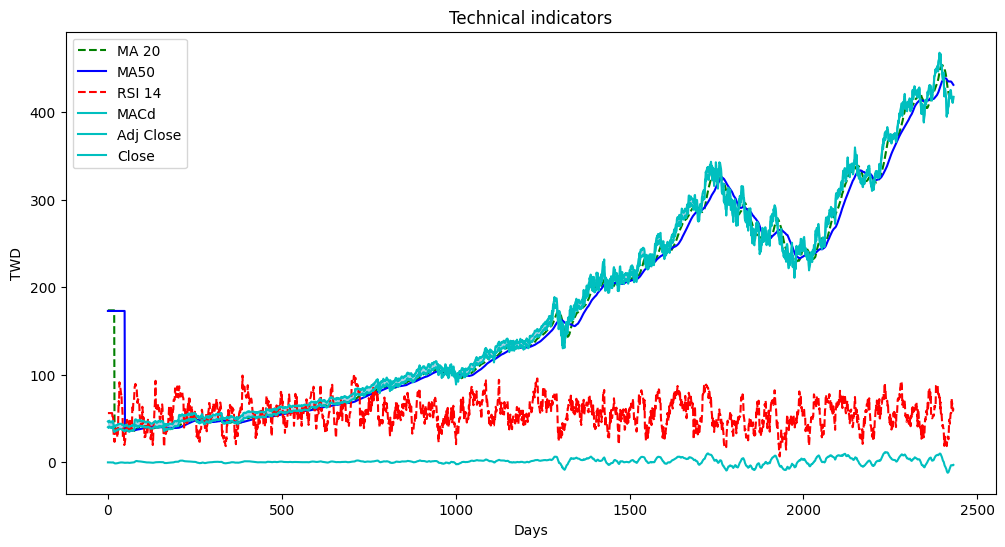

In [188]:
x_ = np.arange(stocks.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(stocks['MSFT_MA20'].values, label = 'MA 20', color = 'g', linestyle = '--')
plt.plot(stocks['MSFT_MA50'].values, label = 'MA50', color = 'b')
plt.plot(stocks['MSFT_RSI14'].values, label = 'RSI 14', color = 'r', linestyle = '--')
plt.plot(stocks['MSFT_MACD'].values, label = 'MACd', color = 'c')
plt.plot(stocks['MSFT_Adj Close'].values, label = 'Adj Close', color = 'c')
plt.plot(stocks['MSFT_Close'].values, label = 'Close', color = 'c')
plt.fill_between(x_, stocks['MSFT_Adj Close'].values, stocks['MSFT_Close'].values, alpha = 0.35)
plt.title('Technical indicators')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend()

In [189]:
stocks['y'] = stocks['MSFT_Close']

x = stocks.iloc[:, :96].values
y = stocks.iloc[:, 96].values

split = int(stocks.shape[0]* 0.75)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (1824, 96) trainY: (1824,)
testX: (608, 96) testY: (608,)


In [190]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [191]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([96, 400, 400, 400, 10], 10)

[1/240] Loss: 519.9144172668457
[2/240] Loss: 490.49198627471924
[3/240] Loss: 478.33244800567627
[4/240] Loss: 476.9999532699585
[5/240] Loss: 475.4481153488159
[6/240] Loss: 465.5063314437866
[7/240] Loss: 456.8513641357422
[8/240] Loss: 452.6692361831665
[9/240] Loss: 450.2789077758789
[10/240] Loss: 447.0274991989136
[11/240] Loss: 442.9970283508301
[12/240] Loss: 441.9619731903076
[13/240] Loss: 439.8418560028076
[14/240] Loss: 433.5285758972168
[15/240] Loss: 428.69870948791504
[16/240] Loss: 427.5421304702759
[17/240] Loss: 426.05846786499023
[18/240] Loss: 421.25604248046875
[19/240] Loss: 414.2098112106323
[20/240] Loss: 408.596483707428
[21/240] Loss: 407.14634799957275
[22/240] Loss: 407.6648073196411
[23/240] Loss: 403.5980234146118
[24/240] Loss: 395.172390460968
[25/240] Loss: 388.71244859695435
[26/240] Loss: 386.4309768676758
[27/240] Loss: 385.75662183761597
[28/240] Loss: 384.50818061828613
[29/240] Loss: 382.16428804397583
[30/240] Loss: 378.759717464447
[31/240] Los

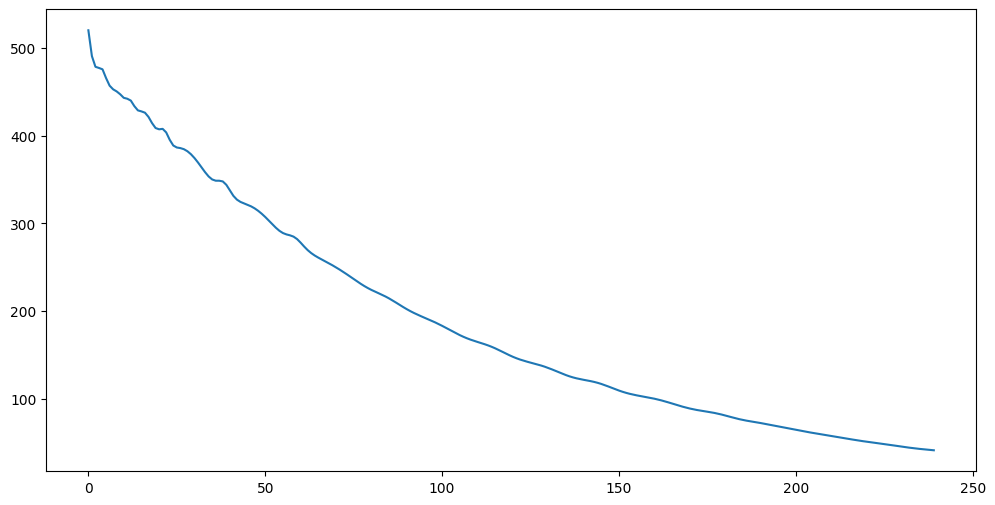

In [192]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 240
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [193]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [194]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [195]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [196]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([1821, 3, 106]) train_y: torch.Size([1821, 1]) train_y_gan: torch.Size([1821, 4, 1])
test_x: torch.Size([605, 3, 106]) test_y: torch.Size([605, 1]) test_y_gan: torch.Size([605, 4, 1])


In [197]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.conv4 = nn.Conv1d(128, 256, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(256, 420)
        self.batch1 = nn.BatchNorm1d(420)
        self.linear2 = nn.Linear(420, 420)
        self.batch2 = nn.BatchNorm1d(420)
        self.linear3 = nn.Linear(420, 1)
        self.leaky = nn.LeakyReLU(0.05)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        conv4 = self.conv4(conv3)
        conv4 = self.leaky(conv4)
        flatten_x = conv4.reshape(conv4.shape[0], conv4.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [198]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.00018
num_epochs = 135

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(106).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/135] LossD: 20.79460370540619 LossG:10.396710634231567
[2/135] LossD: 20.794313311576843 LossG:10.3993581533432
[3/135] LossD: 20.794560074806213 LossG:10.394075572490692
[4/135] LossD: 20.79454791545868 LossG:10.399432003498077
[5/135] LossD: 20.794541478157043 LossG:10.395651042461395
[6/135] LossD: 20.79454755783081 LossG:10.39912360906601
[7/135] LossD: 20.794495701789856 LossG:10.395551681518555
[8/135] LossD: 20.794513463974 LossG:10.39951628446579
[9/135] LossD: 20.794419527053833 LossG:10.395622789859772
[10/135] LossD: 20.794443607330322 LossG:10.399226009845734
[11/135] LossD: 20.794421672821045 LossG:10.395717561244965
[12/135] LossD: 20.794339060783386 LossG:10.399006128311157
[13/135] LossD: 20.794232726097107 LossG:10.396220088005066
[14/135] LossD: 20.794070959091187 LossG:10.399385392665863
[15/135] LossD: 20.79410970211029 LossG:10.395901441574097
[16/135] LossD: 20.79375684261322 LossG:10.400043964385986
[17/135] LossD: 20.793373346328735 LossG:10.397360146045685
[

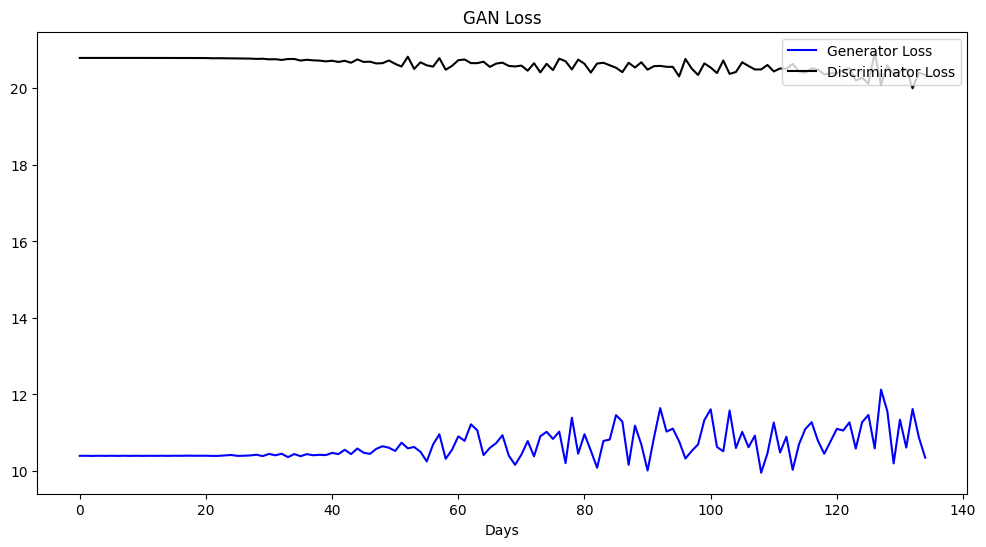

In [199]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [200]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))


y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:9.424769341454898


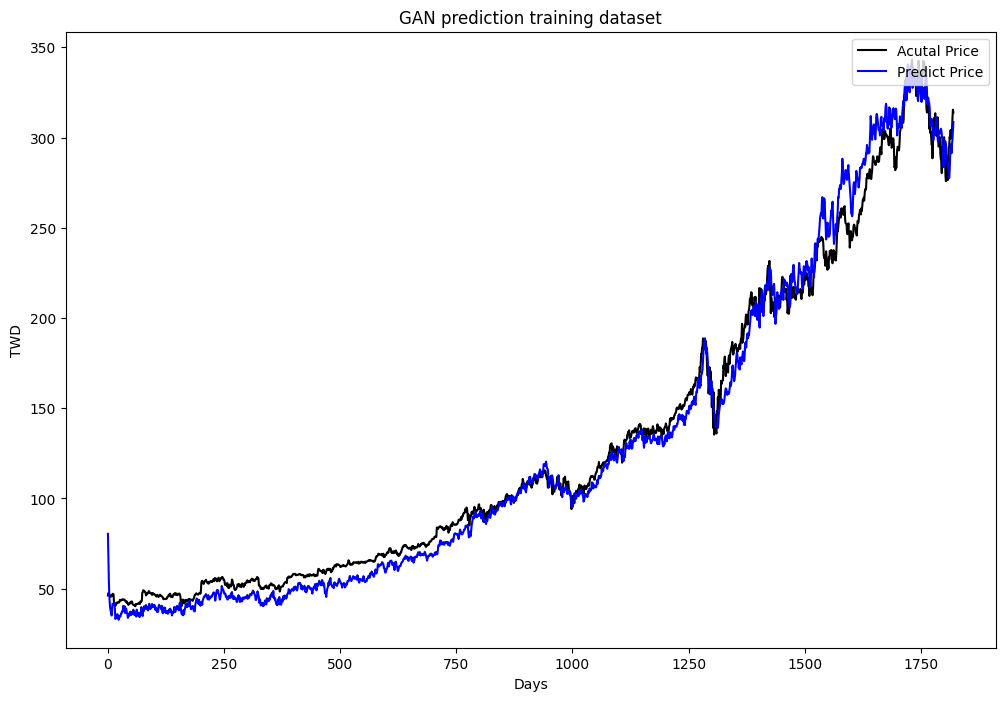

In [201]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')



Test dataset RMSE:38.26109291985537


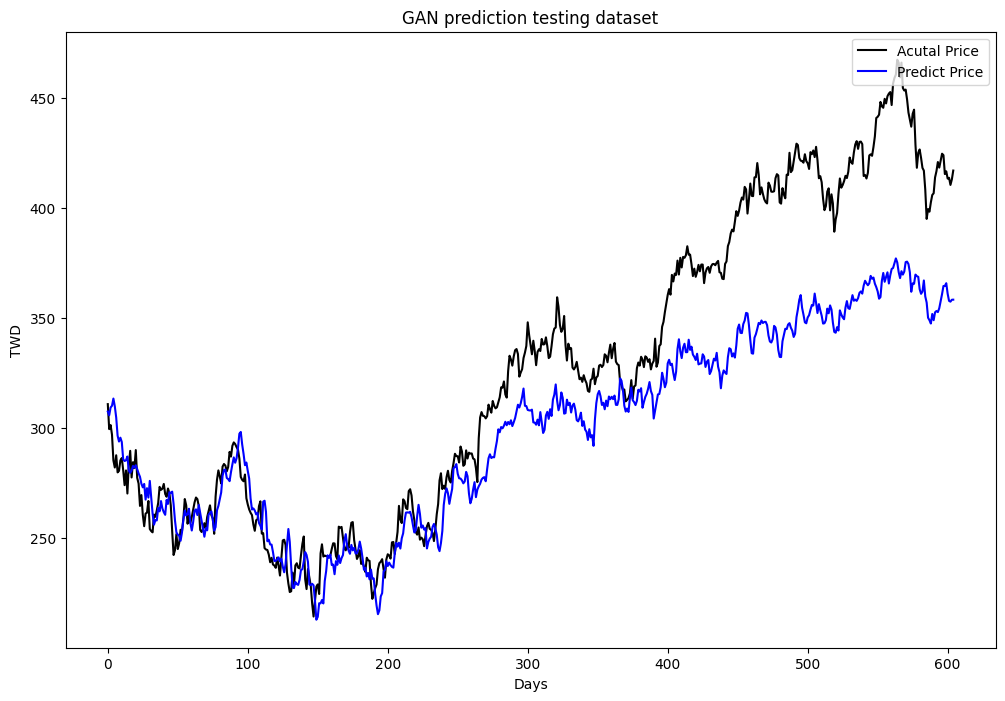

In [202]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE_test = mean_squared_error(y_test_true, y_test_pred)
RMSE_test = math.sqrt(MSE_test)
print(f'Test dataset RMSE:{RMSE_test}')

In [203]:
import pandas as pd

df = pd.DataFrame({
    'Predicted Price': y_test_pred.flatten(),
    'Actual Price': y_test_true.flatten()
})

print(df)


     Predicted Price  Actual Price
0         307.503357    310.880008
1         305.807404    299.499993
2         309.353607    301.369991
3         310.148346    296.969997
4         313.422089    285.260002
..               ...           ...
600       361.088928    413.489988
601       357.840576    413.840004
602       357.498993    410.600014
603       358.380859    413.120010
604       358.399567    417.140026

[605 rows x 2 columns]


In [204]:
df.head(20)

,Predicted Price,Actual Price
0,307.503357,310.880008
1,305.807404,299.499993
2,309.353607,301.369991
3,310.148346,296.969997
4,313.422089,285.260002
5,309.910065,282.059992
6,304.803528,287.619989
7,296.546844,279.829979
8,293.857941,280.519992
9,295.616455,285.299981
